In [1]:
# default_exp capsAnalaysis

In [2]:
import sys

In [3]:
sys.path.append('/workspace/oct_ca_seg/oct/')

In [4]:
from oct.startup import *
from model import CapsNet
import numpy as np
import mlflow
from fastai.vision import *
import mlflow.pytorch as MLPY
from fastai.utils.mem import gpu_mem_get_all
from skimage import filters

In [5]:
gpu_mem_get_all()

[GPUMemory(total=16280, free=16270, used=10)]

In [6]:
cocodata_path = Path('/workspace/oct_ca_seg/COCOdata/')
train_path = cocodata_path/'train/images'
valid_path = cocodata_path/'valid/images'
test_path = cocodata_path/'test/images'

In [7]:
metrics = [sens, spec, dice, my_Dice_Loss, acc]

In [8]:
runsave_dir = Path('/workspace/oct_ca_seg/runsaves/')

In [9]:
run_name = 'DEEPCAP_0001_30_learnersaved'
cfg_file = 'configCAPS_APPresnet18_bs16_epochs15_lr0.001.json'

In [10]:
run_name = 'DEEPCAP_0001_30_small_learnersaved'
cfg_file = 'configCAPS_small_bs24_epochs30_lr0.001.json'

In [11]:
run_name = 'DEEPCAP_0001_30_smooth_small_learnersaved' # i put blurring in the finer detai parts of the model leading to poorly demarcated labels
cfg_file = 'configCAPS_small_bs24_epochs30_lr0.001.json'

In [12]:
run_name = 'DEEPCAP_0001_30_final_smooth_small_learnersaved' 
cfg_file = 'configCAPS_small_bs24_epochs30_lr0.001.json'

In [28]:
run_name = 'DEEPCAP_03start_30e_001lr_fsmooth' #best
cfg_file = 'configCAPS_small_bs24_epochs30_lr0.001.json'

In [16]:
run_name = 'DEEPCAP_09start_30e_001lr_fsmooth' #best
cfg_file = 'configCAPS_small_bs24_epochs30_lr0.001.json'

In [29]:
run_dir = runsave_dir/run_name

In [30]:
def loadConfigRun(run_dir, name):
    with open(run_dir/name, 'r') as file:
        return json.load(file)

In [31]:
cfg_dict = loadConfigRun(run_dir, cfg_file)

In [32]:
#cfg_dict['LEARNER']['bs'] = 1

In [33]:
config = DeepConfig(cfg_dict)

## Train, Valid

In [20]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(cocodata_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_folder('train', 'valid')
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size=config.LEARNER.img_size)
data = src.databunch(cocodata_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
data.normalize(stats);
data.c_in, data.c_out = 3, 2

## Test

In [38]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(test_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_rand_pct(0.90)
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size =config.LEARNER.img_size)
data = src.databunch(test_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
#stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
stats = data.batch_stats()
data.normalize(stats);
data.c_in, data.c_out = 3, 2

## Load Model

In [39]:
deepCap = CapsNet(config.MODEL).cuda()
learn = Learner(data = data,
                  model = deepCap,
                  metrics = metrics)

### LR finder

In [ ]:
lr_find(learn)

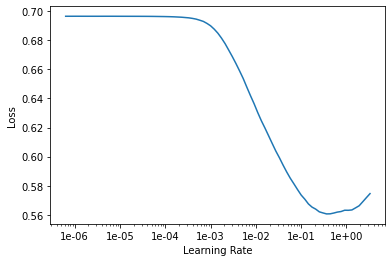

In [24]:
learn.recorder.plot()

## Run Analysis

In [40]:
learn = learn.load(run_dir/'learner')

In [41]:
class Analysis():
    def __init__(self, learner:Learner, run_dir:Path):
        self.learner = learner
        self.run_dir = run_dir
        self.metrics = pd.read_json(self.run_dir/'metrics.json')
        self.trainL =  pd.read_json(self.run_dir/'trainL.json')
        self.validL =  pd.read_json(self.run_dir/'validL.json')
    
    def remove0FromMetric(self, metric):
        zero_dict = {k:v for (k,v) in self.results[metric].items() if v==0}
        zero_dict = {k: v for k, v in sorted(zero_dict.items(), key=lambda item: item[1])}
        new_dict = {k:v for (k,v) in self.results[metric].items() if v!=0}
        new_dict = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1])}
        print('there were ', len(zero_dict.keys()), 'zeros in the ', metric,' list.')
        return zero_dict, new_dict
    
    def histPlotMetric(self, metric, save=False):
        #metric = one of 'dices', 'sens', 'specs', 'accs' 
        zeros, actual = self.remove0FromMetric(metric)
        l_actual = list(actual.values())
        l_actual = [x for x in l_actual if x==x] # get rid of nans
        mean, std, median, max, min = np.mean(l_actual), np.std(l_actual), np.median(l_actual), np.max(l_actual), np.min(l_actual)
        print(mean, std, median, max, min)
        plt.hist(l_actual)
        if save: plt.savefig(self.checkpoint_path/(metric+'.png'))
        #return l_actual
    
    def showPrediction(self, id):
        self.learner.model.eval()
        batch = self.learner.data.one_batch(ds_type=DatasetType.Valid, denorm=False, detach=True, cpu=False)
        img = self.learner.data.one_batch(ds_type=DatasetType.Valid, denorm=True, detach=True, cpu=True)[0]
        xb = batch[0][id]#.permute(1,2,0).cpu()
        yb = batch[1][id][0]#.permute(1,2,0).cpu()
        pb = self.learner.model(xb.unsqueeze(0).cuda())[0]
        #print(xb.size(), yb.size(), pb.size())
        fig, (axim, axl, axp) = plt.subplots(nrows=1, ncols=3, figsize=(16, 3.5),
                    subplot_kw={'xticks': [], 'yticks': []})
        #images
        im = axim.imshow(img[id].permute(1,2,0))
        axim.set_title('Image')
        l = axl.imshow(yb.cpu())
        axl.set_title('Label')
        p = axp.imshow(torch.argmax(pb.detach().cpu(), dim=0))
        print()
        axp.set_title('Pred')
        
        #return xb.size(), yb.size(), pb.size()

In [42]:
CapsAnalysis = Analysis(learn, run_dir)

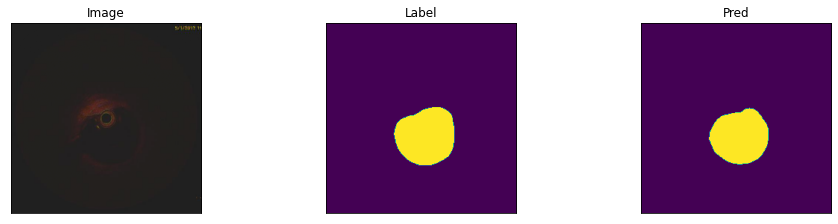

In [43]:
CapsAnalysis.showPrediction(0)*

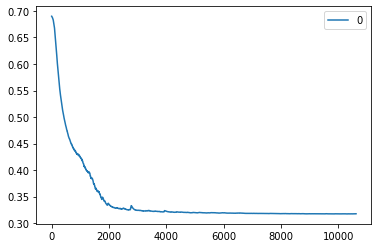

In [44]:
CapsAnalysis.trainL.sort_index().plot.line()

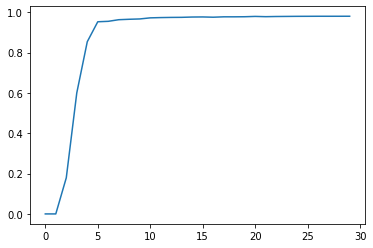

In [45]:
CapsAnalysis.metrics['dice'].sort_index().plot.line()

In [37]:
CapsAnalysis.metrics;

## test loop

In [47]:
xb,yb=data.one_batch(denorm=False,cpu=False)

In [58]:
%%time 
pb = learn.model(xb)

CPU times: user 31.1 ms, sys: 0 ns, total: 31.1 ms
Wall time: 28.9 ms


In [59]:
learn.model.eval();

In [60]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(test_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_rand_pct(0.90)
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size=config.LEARNER.img_size)
data = src.databunch(test_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
#stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
stats = data.batch_stats()
data.normalize(stats);
data.c_in, data.c_out = 3, 2

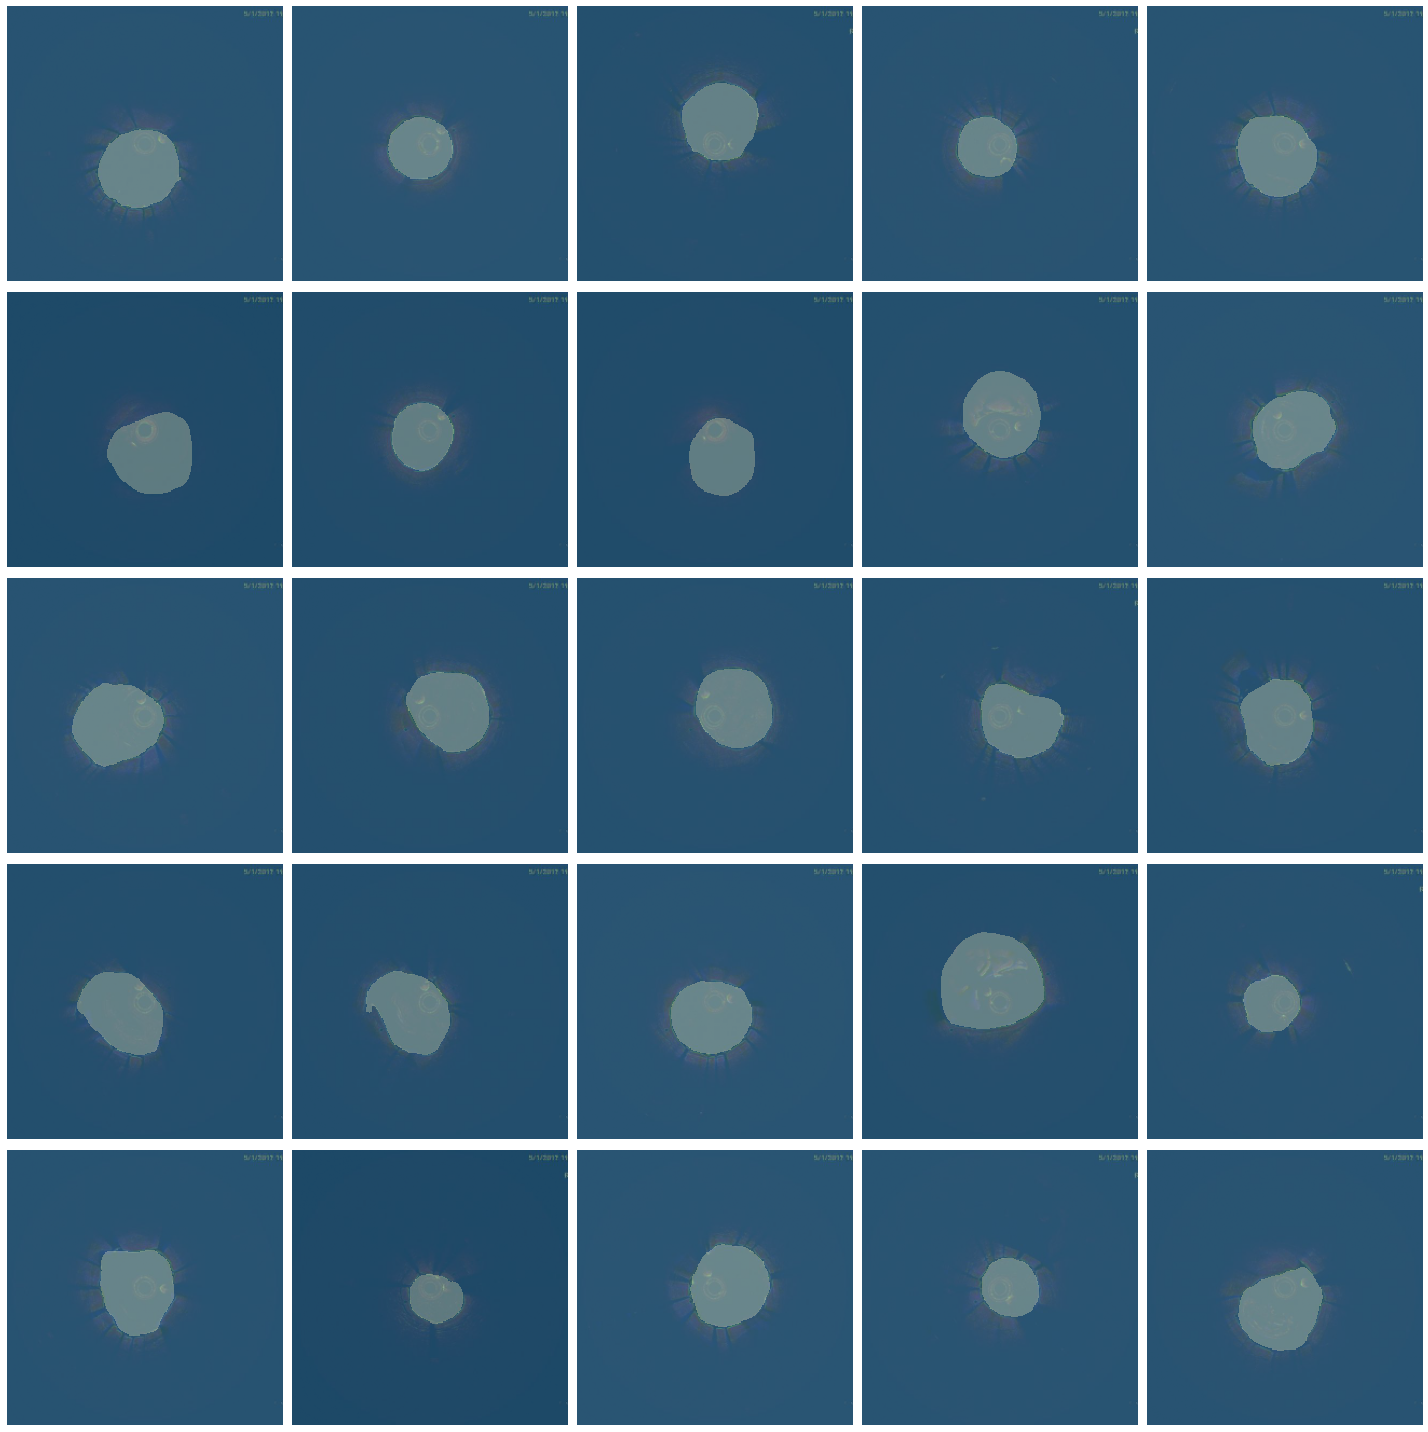

In [61]:
data.show_batch(ds_type=DatasetType.Valid)

In [62]:
deepCap = CapsNet(config.MODEL).cuda()
learn = Learner(data = data,
                  model = deepCap,
                  metrics = metrics)

In [63]:
learn = learn.load(run_dir/'learner')

In [64]:
learn.model.eval();

In [1]:
%%time
preds,targs = learn.get_preds()

NameError: name 'learn' is not defined

In [66]:
preds.size(), targs.size()

(torch.Size([909, 2, 256, 256]), torch.Size([909, 1, 256, 256]))

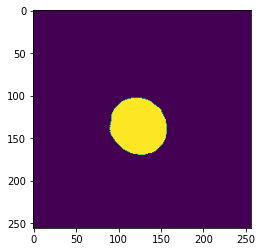

In [70]:
plt.imshow(targs[100,0])

(<matplotlib.image.AxesImage at 0x2b43303b1cd0>, 0.9838958382606506)

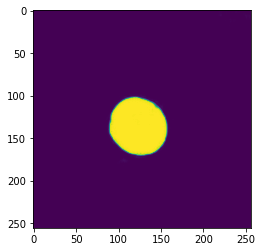

In [69]:
n = 100
plt.imshow(preds[n,1]), dice(preds[n].unsqueeze(0), targs[n].unsqueeze(0)).item()

In [71]:
%%time
recorder = []
for p,y in iter(zip(preds,targs)): 
    p = p.unsqueeze(0)
    y = y.unsqueeze(0)
    recorder.append([met(p, y).item() for met in metrics])

CPU times: user 40min 41s, sys: 4.86 s, total: 40min 46s
Wall time: 1min 27s


In [72]:
test_results = pd.DataFrame(recorder, columns=[met.__name__ for met in learn.metrics])

In [73]:
test_results.mean(axis=0)

sens            0.949489
spec            0.996556
dice            0.972657
my_Dice_Loss    0.880539
acc             0.035721
dtype: float64

In [74]:
test_results.std(axis=0)

sens            0.064204
spec            0.005743
dice            0.043941
my_Dice_Loss    0.029051
acc             0.000000
dtype: float64

In [75]:
test_results.median(axis=0)

sens            0.965462
spec            0.997811
dice            0.982428
my_Dice_Loss    0.879314
acc             0.035721
dtype: float64

In [76]:
test_results.min(axis=0)

sens            0.335110
spec            0.927339
dice            0.501996
my_Dice_Loss    0.796850
acc             0.035721
dtype: float64

In [77]:
test_results.max(axis=0)

sens            0.985503
spec            0.999463
dice            0.992698
my_Dice_Loss    0.945615
acc             0.035721
dtype: float64

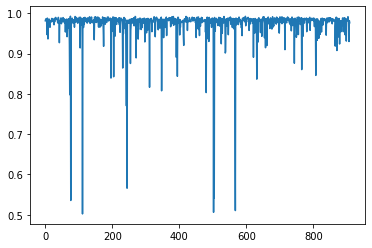

In [78]:
test_results['dice'].plot.line()

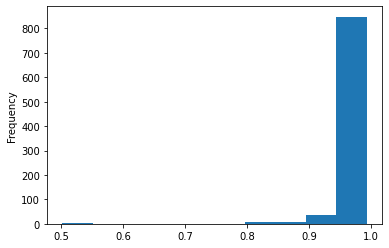

In [79]:
test_results['dice'].plot.hist()

In [41]:
test_results.to_json(run_dir/'test_results.json')

In [80]:
test_results.sort_values(by='dice')

,sens,spec,dice,my_Dice_Loss,acc
111,0.335110,0.965126,0.501996,0.897151,0.035721
502,0.338758,0.927339,0.506079,0.803789,0.035721
567,0.342598,0.928886,0.510351,0.806279,0.035721
76,0.365562,0.960262,0.535401,0.892041,0.035721
504,0.370741,0.930162,0.540936,0.802211,0.035721
...,...,...,...,...,...
268,0.984338,0.999266,0.992107,0.912297,0.035721
89,0.984348,0.998960,0.992112,0.886085,0.035721
420,0.984581,0.999463,0.992230,0.933774,0.035721
597,0.985128,0.998762,0.992508,0.848267,0.035721


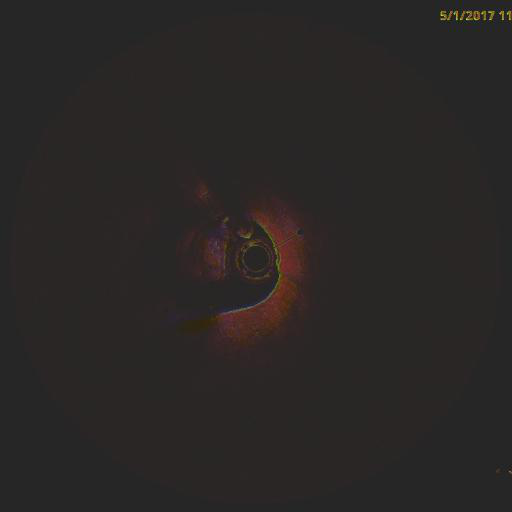

In [82]:
learn.data.valid_ds.x[111]

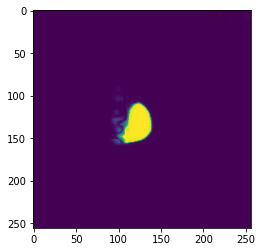

In [85]:
plt.imshow(preds[111][1])

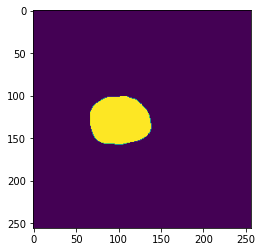

In [86]:
plt.imshow(targs[111][0])

In [166]:
learn.validate(metrics=metrics)

[0.31771377,
 tensor(0.9490),
 tensor(0.9965),
 tensor(0.9725),
 tensor(-4.5412),
 tensor(0.9404)]